# Debye Shielding

Text adapted from [1]: _A fundamental property of plasmas is their quasi-neutrality, i.e. on a
macroscopic scale the overall charge density of positive and negative particles will cancel
out. However, within local regions of characteristic length $\lambda_D = v_{th}/\omega_p$ (referred to as
the Debye length) the local electric fields generated by a charged particle will not be fully
screened by the oppositely charged particles. We expect to observe the same behavior
for the sheet model. More precisely, the density of sheets at a certain distance from a
test position is expected to follow_ [2]:

$$
n(x) = n_0 \left(1 - \frac{\delta}{2\lambda_D} e^{-|x|/\lambda_D}\right).
$$

*where $\delta$ is the intersheet spacing in equilibrium and $n_0$ the ion number density of (in our case $n_0 = 1 ~\delta^{-1}$)*.


In this notebook we demonstrate this phenomena by initializing systems with different Debye lengths (by sampling initial sheet velocities from a gaussian distribution with standard deviation ~$v_{th}$), and then measuring the number sheets at a certain distance from a test sheet (averaged over several time-steps and test sheets).

#### References
[1] D. Carvalho et al., arXiv:2310.17646 (2023) - See Section 6.2 <br>
[2] J. Dawson, Phys. Fluids 5.4 (1962) - See pp. 450

In [2]:
import os
import sys
import jax
import numpy as np

# uncomment the line below for nicer plots (needs LaTeX)
# os.environ['MATPLOTLIBRC'] = '../matplotlibrc'
import matplotlib.pyplot as plt

sys.path.append('../..')
from sheet_model.utils import get_relaxation_time, get_dx_eq, get_x_eq
from gns.simulator import SMGNS

## dont let JAX preallocate all GPU memory + free unused arrays 
## https://jax.readthedocs.io/en/latest/gpu_memory_allocation.html
## makes code slower
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false" 
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

## Single $\lambda_d$

### User Defined

In [2]:
n_sheets = 10000
boundary = 'periodic'

# initial velocity distribution std
# It is not v_th! 
# v_th will be slightly smaller since some of the initial kinetic energy  will be deposited in the fields
v_std_0 = 5.2 # [dx_eq w_p]

# GNS model
gns = SMGNS('../../models/final/dt1e-1/4/', boundary)

Simulator Info
   GNN model: ../../models/final/dt1e-1/4
   boundary: periodic
   L: 1
   dt_train: 0.1
   Training Dataset
      L: 1.0
      augment_t: True
      augment_x: True
      boundary: periodic
      data_folder: data/dataset/train/10/periodic/
      dt_simulator: 0.01
      dt_undersample: 10
      mode: crossings
      n_neighbors: 1
      n_sheets: 10
      save_folder: data/processed_temp/train/dt1e-1
      var_target: dvdt
      w_size: 1


### Run Simulation

In [3]:
# reproducibility
np.random.seed(42)

# aux variables
t_relax = get_relaxation_time(v_std_0) # this is in an overestimation of the relaxation time since v_th < v_std_0
dx_eq = get_dx_eq(n_sheets)
x_eq = get_x_eq(n_sheets)

# intial x/v values
x_0 = np.copy(x_eq)
v_0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

# simulation time
# a larger value will produce more statistics and a better aggreement with the theory
t_max = t_relax * 80

X, V, _, E = gns.pred_rollout(x_0,
                              v_0,
                              x_eq,
                              t_max=t_max,
                              verbose=True,
                              track_sheets=False,
                              np_=np)

print(f'DE/E_0: {(E[-1]-E[0])/E[0]:.2e}')

  0%|          | 0/10427 [00:00<?, ?it/s]

DE/E_0: 6.15e-03


### Compute Correct $\lambda_D$

In [4]:
# only sample once every t_relaxation
# ensures that samples are statistically independent
t_min = t_relax
t = np.arange(t_min, t_max, t_relax)
it = t / gns.dt_train
it = it.astype(np.int64)

# lambda_d == v_th in our units
lambda_d = np.std(V[it].flatten()/ dx_eq) 
print(f'lambda_d: {lambda_d:.2f} [dx_eq]')

lambda_d: 5.00


### Simulation Results vs Theory

In [5]:
def get_sheet_density(X: np.ndarray, n_skip: int, d_dx: float, d_max: float, verbose=True):
    """
    Computes sheet density relative to equally spaced test sheets.
    
    Args:
        X - sheet positions (#timesteps, #sheets)
        n_skip - number of sheets between consecutive test sheets
        d_dx - spatial resolution of the density measure
        d_max - max distance from test sheet at which sheet density is measured
    
    Returns:
        d_range - distance from test sheets at which sheet density was measured
        density - sheet density
        density_error - associated density error
    """
    # array with distances from test sheet to check
    d_range = np.arange(d_dx, d_max + d_dx, d_dx) - d_dx/2.
    
    # buffer to store counts for each test sheet / timestep
    aux = []
    # loop over time
    for i in range(X.shape[0]):
        # compute distances to every test_sheet
        dX = X[i].reshape(-1,1) - X[i,int(np.ceil(d_max)):-int(np.ceil(d_max)):n_skip].reshape(1,-1)
        counts = np.sum([np.logical_and(np.abs(dX) <= ((d+d_dx/2) * dx_eq), 
                                        np.abs(dX) > (d-d_dx/2) * dx_eq) for d in d_range], axis=1)
        aux.append(counts)
    
    # shape = (#timesteps, #distances, #sheets)
    aux = np.array(aux)
    # number of samples per checked distance
    N = aux.shape[0] * aux.shape[-1]
    
    if verbose:
        print('#time-steps', len(it))
        print('#sheets/time-step', dX.shape[-1])
        print('#samples', N)
    
    # mean over particles and time-steps
    counts = np.sum(np.sum(aux, axis=-1), axis=0)
    density = counts / (N * 2 * d_dx)
    density_error = np.sqrt(counts) / (N * 2 * d_dx)
    
    return d_range, density, density_error

def theoretical_curve(x):
    """
    Solution obtained from linearized Debye theory J.Dawson (1962)
        https://aip.scitation.org/doi/abs/10.1063/1.1706638
        
    Args:
        x - distance from target sheet [lambda_d]
    """
    return 1 - 1/(2 * lambda_d) * np.exp(-x/lambda_d)

In [6]:
# max distance from test sheet to check
d_max = lambda_d * 4 # [dx_eq]
# resolution
d_dx = d_max/20. # [dx_eq]
# number of sheets to skip between consecutive test sheets
n_skip = int(np.ceil(d_max))

d_range, density, density_error = get_sheet_density(X[it], n_skip, d_dx, d_max)

#time-steps 79
#sheets/time-step 498
#samples 39342


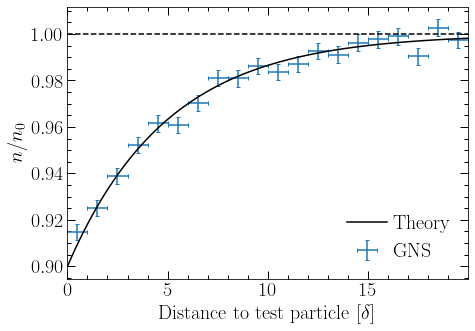

In [7]:
plt.figure()
plt.errorbar(d_range, density, yerr=density_error, xerr=d_dx/2, capsize=2, ls='', label='GNS')
plt.plot(np.linspace(0,d_max + d_dx/2,100), 
         theoretical_curve(np.linspace(0,d_max + d_dx/2,100)), label='Theory', color='black')

plt.axhline(1, color='k', linestyle='--')
plt.xlabel('Distance to test particle [$\delta$]')
plt.ylabel('$n$/$n_0$')
plt.xlim(0, d_max)
plt.legend()
plt.tight_layout()
plt.savefig('../img/debye_shielding_single')
plt.show()

## Multiple $\lambda_D$

### User Defined

In [8]:
n_sheets = 10000
boundary = 'periodic'
V_STD_0 = [1.7, 2.7, 5.25] # always set a value slightly higher than the desired lambda_D
gns = SMGNS('../../models/final/dt1e-1/4/', boundary, verbose=False)

### Run Simulations


v_std_0: 1.7 [dx_eq w_p]
t_relax: 4.26 [w_p^-1]


  0%|          | 0/3409 [00:00<?, ?it/s]

DE/E_0: 4.92e-03
lambda_d: 1.50 [dx_eq]

v_std_0: 2.7 [dx_eq w_p]
t_relax: 6.77 [w_p^-1]


  0%|          | 0/5414 [00:00<?, ?it/s]

DE/E_0: 6.19e-03
lambda_d: 2.48 [dx_eq]

v_std_0: 5.25 [dx_eq w_p]
t_relax: 13.16 [w_p^-1]


  0%|          | 0/10527 [00:00<?, ?it/s]

DE/E_0: 6.70e-03
lambda_d: 4.99 [dx_eq]


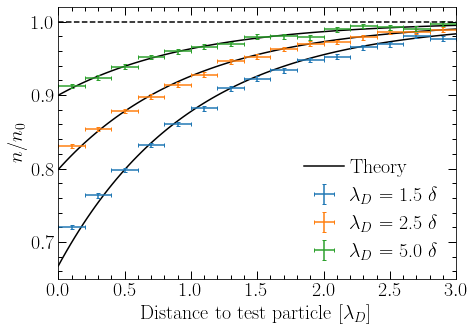

In [9]:
np.random.seed(42)
dx_eq = get_dx_eq(n_sheets)
x_eq = get_x_eq(n_sheets)

fig = plt.figure()

for iv, v_std_0 in enumerate(V_STD_0):
    
    print()
    print(f'v_std_0: {v_std_0} [dx_eq w_p]')
    
    t_relax = get_relaxation_time(v_std_0)
    
    print(f't_relax: {t_relax:.2f} [w_p^-1]')
    
    x_0 = np.copy(x_eq)
    v_0 = np.random.normal(0, v_std_0, n_sheets) * dx_eq

    t_max = t_relax * 80
    
    X, V, _, E = gns.pred_rollout(x_0,
                                  v_0,
                                  x_eq,
                                  t_max=t_max,
                                  verbose=True,
                                  track_sheets=False,
                                  np_=np)

    
    print(f'DE/E_0: {(E[-1]-E[0])/E[0]:.2e}') 
    
    t_min = t_relax
    t = np.arange(t_min, t_max, t_relax)
    it = t / gns.dt_train
    it = it.astype(np.int64)
    
    X = X[it]
    V = V[it]

    lambda_d = np.std(V[-3:].flatten()/ dx_eq) 
          
    print(f'lambda_d: {lambda_d:.2f} [dx_eq]')
    
    d_max = lambda_d * 3 
    d_dx = d_max/15.
    n_skip = int(np.ceil(d_max))
    
    d_range, density, density_error = get_sheet_density(X, n_skip, d_dx, d_max, False)
    
    
    plt.plot(np.linspace(0, d_max + d_dx/2, 100)/lambda_d, 
             theoretical_curve(np.linspace(0, d_max + d_dx/2, 100)), 
             label='Theory' if iv==0 else None, color='black')
    
    plt.errorbar(d_range/lambda_d, 
                 density, 
                 yerr=density_error, 
                 xerr=d_dx/2/lambda_d, 
                 capsize=2, ls='', label=f'$\lambda_D$ = {lambda_d:.1f} $\delta$')


plt.axhline(1, color='k', linestyle='--')
plt.xlabel('Distance to test particle [$\lambda_D$]')
plt.ylabel('$n$/$n_0$')
plt.ylim(0.65, 1.02)
plt.xlim(0, d_max/lambda_d)
plt.legend()
plt.tight_layout()
plt.savefig('../img/debye_shielding_multi')
plt.show()